# Wine Case Analysis: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [242]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [243]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [244]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine_00 = pd.read_csv('./Wine_Hier00.csv')
df_Wine_01 = pd.read_csv('./Wine_Hier01.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [245]:
df_Wine_00.shape

(3301, 25)

In [246]:
df_Wine_00 = df_Wine_00.rename(columns={'lat': 'Latitude', 'long': 'Longitude'})
df_Wine_00.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
Latitude              float64
Longitude             float64
altitude              float64
dtype: object

In [247]:
df_Wine_01 = df_Wine_01.rename(columns={'lat': 'Latitude', 'long': 'Longitude'})
df_Wine_01.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
Latitude              float64
Longitude             float64
altitude              float64
dtype: object

In [248]:
df_Wine_01.shape

(3301, 25)

In [249]:
df_Wine_01.shape

(3301, 25)

In [250]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine_00.drop(df_Wine_00.tail(n).index, inplace = True)
df_Wine_01.drop(df_Wine_01.tail(n).index, inplace = True)

In [251]:
# Review_Year
# Convert Review_Year from float to int
df_Wine_00['Review_Year'] = df_Wine_00['Review_Year'].astype(int)
df_Wine_01['Review_Year'] = df_Wine_01['Review_Year'].astype(int)

In [252]:
# Limit dataset to Wines with a single grape instead of a blend
df_Wine_00 = df_Wine_00[ (df_Wine_00.Grape_Blend != 'Blend') ]
df_Wine_01 = df_Wine_01[ (df_Wine_01.Grape_Blend != 'Blend') ]

print(df_Wine_00.shape)
print(df_Wine_01.shape)

(2420, 25)
(2421, 25)


In [253]:
df_GeoCache.shape

(1224, 8)

In [254]:
df_Flag.shape

(19, 3)

In [255]:
df_Wine_00.sample(10)

Review_Year Rank Vintage  Score Price              Winemaker  \
2589         1995   90    1994   90.0    20            Glen Carlou   
491          2016   92    2015   91.0    23        Philippe Alliet   
1520         2005   21    2002   97.0    85  Barossa Valley Estate   
2225         1998    9    1996   93.0    28             Chalk Hill   
2871         1992   72    1989   91.0    14                  Mietz   
2053         2000   54    1998   92.0    28                Raymond   
3088         1990   89    1989   90.0     9        Kendall-Jackson   
733          2013   34    2010   91.0    20       Bodegas Valdemar   
2899         1992  100    1990   90.0    17                Sanford   
85           2020   86    2018   91.0    26         Château Thivin   

                                               Wine Wine_Style  \
2589                               Chardonnay Paarl      White   
491                                          Chinon        Red   
1520         Shiraz Barossa Valley E&E Black Pepper        Red   
2225                          Chardonnay Chalk Hill      White   
2871                           Merlot Sonoma County        Red   
2053         Cabernet Sauvignon Napa Valley Reserve        Red   
3088  Sauvignon Blanc Lake County Vintner's Reserve      White   
733                     Rioja Inspiración Selección        Red   
2899                Pinot Noir Santa Barbara County        Red   
85                               Brouilly Reverdon         Red   

              Grape_Blend Blend_List  ... Best_Drink_from  Best_Drink_Through  \
2589          Chardonnay         NaN  ...          1995.0              1997.0   
491        Cabernet Franc        NaN  ...          2016.0              2020.0   
1520       Shiraz | Syrah        NaN  ...          2010.0              2022.0   
2225          Chardonnay         NaN  ...          1998.0              2002.0   
2871               Merlot        NaN  ...          1992.0              1997.0   
2053  Cabernet Sauvignon         NaN  ...          2001.0              2009.0   
3088      Sauvignon Blanc        NaN  ...             NaN                 NaN   
733                 Rioja        NaN  ...          2013.0              2018.0   
2899           Pinot Noir        NaN  ...          1992.0                 NaN   
85                  Gamay        NaN  ...          2020.0              2024.0   

                                                 Review     Hierarchy  \
2589  Incredibly complex. Like a premier cru white B...  Hierarchy_00   
491   Lovely cherry pit, damson plum and violet note...  Hierarchy_00   
1520  Dark, juicy and profound, with layer upon laye...  Hierarchy_00   
2225  Bold, ripe, complex and concentrated in style,...  Hierarchy_00   
2871  A beautifully harmonious wine, with intense fr...  Hierarchy_00   
2053  A nice round red, with ripe flavors of black c...  Hierarchy_00   
3088  With powerful grassy, fruity aromas, full, cri...  Hierarchy_00   
733   Fresh and focused, this sleek, lively red show...  Hierarchy_00   
2899  Complex and intriguing for its band of flavors...  Hierarchy_00   
85    Lively acidity cuts through the bright cherry ...  Hierarchy_00   

           Address            loc                            point   Latitude  \
2589  South Africa   South Africa    (-28.8166236, 24.991639, 0.0) -28.816624   
491         France         France      (46.603354, 1.8883335, 0.0)  46.603354   
1520     Australia      Australia      (-24.7761086, 134.755, 0.0) -24.776109   
2225           USA  United States  (39.7837304, -100.4458825, 0.0)  39.783730   
2871           USA  United States  (39.7837304, -100.4458825, 0.0)  39.783730   
2053           USA  United States  (39.7837304, -100.4458825, 0.0)  39.783730   
3088           USA  United States  (39.7837304, -100.4458825, 0.0)  39.783730   
733          Spain         España    (39.3260685, -4.8379791, 0.0)  39.326068   
2899           USA  United States  (39.7837304, -100.4458825, 0.0)  39.783730   
85

## Pivot on Address

### Hierarchy 00

In [256]:
# Count by Grape by Address - All Years
df_Count_WS_All_00 = pd.DataFrame({'Count' : df_Wine_00.groupby(['Grape_Blend', 'Wine_Style', 'Address','Latitude','Longitude'])['Score'].count()}).reset_index()
df_Count_WS_All_00.sample(10)

Grape_Blend           Wine_Style       Address   Latitude  \
121                  Sangiovese                  Red           USA  39.783730   
56                    Grechetto                White         Italy  42.638426   
37      Chardonnay - Pinot Noir            Sparkling           USA  39.783730   
88        Muscat de Frontignan   Dessert & Fortified  South Africa -28.816624   
29                  Chardonnay                 White       Austria  47.200034   
79                       Merlot                  Red         Chile -31.761336   
10                    Cabernet                   Red        France  46.603354   
127             Sauvignon Blanc                White  South Africa -28.816624   
16          Cabernet Sauvignon                   Red        France  46.603354   
2    Amarone della Valpolicella                  Red         Italy  42.638426   

      Longitude  Count  
121 -100.445882      3  
56    12.674297      1  
37  -100.445882      4  
88    24.991639      1  
29    13.199959      1  
79   -71.318770      3  
10     1.888333      1  
127   24.991639      6  
16     1.888333      1  
2     12.674297      5

In [257]:
# Count by Grape - By Review Year
df_Count_WS_ByYear_00 = pd.DataFrame({'Count' : df_Wine_00.groupby(['Review_Year', 'Grape_Blend', 'Wine_Style', 'Address', 'Latitude', 'Longitude'])['Score'].count()}).reset_index()
df_Count_WS_ByYear_00.sample(10)

Review_Year           Grape_Blend Wine_Style      Address   Latitude  \
274         1998        Shiraz | Syrah        Red    Australia -24.776109   
26          1989  Bordeaux Blend White        Red          USA  39.783730   
410         2003        Shiraz | Syrah        Red       France  46.603354   
847         2015             Zinfandel        Red          USA  39.783730   
940         2018           Chardonnay       White          USA  39.783730   
524         2007   Grenache | Garnacha        Red        Spain  39.326068   
488         2006        Gewürztraminer      White       France  46.603354   
752         2013            Pinot Noir        Red  New Zealand -41.500083   
614         2009        Shiraz | Syrah        Red    Australia -24.776109   
958         2018                 Rioja      White        Spain  39.326068   

      Longitude  Count  
274  134.755000      1  
26  -100.445882      1  
410    1.888333      1  
847 -100.445882      1  
940 -100.445882      5  
524   -4.837979      1  
488    1.888333      1  
752  172.834408      2  
614  134.755000      7  
958   -4.837979      1

### Hierarchy 01

In [258]:
# Count by Grape - All Years
df_Count_All_01 = pd.DataFrame({'Count' : df_Wine_01.groupby(['Grape_Blend', 'Wine_Style', 'Address', 'Latitude', 'Longitude'])['Score'].count()}).reset_index()
df_Count_All_01.sample(10)

Grape_Blend           Wine_Style               Address  \
70                   Falanghina                White       Campania, Italy   
216            Touriga Nacional                  Red    Alentejo, Portugal   
148                  Pinot Noir                  Red   Victoria, Australia   
191              Shiraz | Syrah                  Red  Choapa Valley, Chile   
224                    Viognier                White         Rhône, France   
1                     Aglianico                  Red       Campania, Italy   
7          Bordeaux Blend White                  Red       California, USA   
17          Cabernet Sauvignon                   Red       California, USA   
155                   Primitivo                  Red         Puglia, Italy   
186  Sauvignon Blanc – Semillon  Dessert & Fortified      Bordeaux, France   

      Latitude   Longitude  Count  
70   40.860672   14.843984      3  
216  38.055100   -7.860580      1  
148 -36.598610  144.678005      2  
191 -31.728012  -71.208068      1  
224  45.880235    4.564534      2  
1    40.860672   14.843984      3  
7    36.701463 -118.755997      3  
17   36.701463 -118.755997    265  
155  40.984254   16.621003      5  
186  44.841225   -0.580036      1

In [259]:
# Count by Grape - By Review Year
df_Count_ByYear_01 = pd.DataFrame({'Count' : df_Wine_01.groupby(['Grape_Blend', 'Wine_Style', 'Address', 'Latitude', 'Longitude'])['Score'].count()}).reset_index()
df_Count_ByYear_01.sample(10)

Grape_Blend           Wine_Style                       Address  \
191         Shiraz | Syrah                  Red          Choapa Valley, Chile   
211                 Tannat                  Red     South West France, France   
128           Nero d'Avola                  Red                Sicilia, Italy   
125  Muscat de Frontignan   Dessert & Fortified    Western Cape, South Africa   
59             Chardonnay                 White  Western Australia, Australia   
114                 Merlot                  Red                 New York, USA   
204         Shiraz | Syrah                  Red    Western Cape, South Africa   
139             Pinot Noir                  Red              Burgundy, France   
120            Moscofilero                White           Péloponnèse, Greece   
65                 Chianti                  Red                Tuscany, Italy   

      Latitude   Longitude  Count  
191 -31.728012  -71.208068      1  
211  46.233119    5.354452      2  
128  37.587794   14.155048      4  
125 -33.546977   20.727530      1  
59  -25.230301  121.018725     10  
114  40.712728  -74.006015      1  
204 -33.546977   20.727530      3  
139  47.278087    4.222486     76  
120  37.363328   22.239537      1  
65   43.458654   11.138920     61

### Grape and Wine Style

In [260]:
df_grape_style = pd.DataFrame({'Count' : df_Wine_00.groupby(['Grape_Blend', 'Wine_Style'])['Score'].count()}).reset_index()
df_grape_style = df_grape_style[ (df_grape_style.Count > 24) ]
df_grape_style

Grape_Blend Wine_Style  Count
8    Brunello di Montalcino        Red     70
12      Cabernet Sauvignon         Red    374
16                Champagne  Sparkling     51
18              Chardonnay       White    400
22                  Chianti        Red     61
23      Châteauneuf-du-Pape        Red     66
50                  Malbec         Red     54
56                   Merlot        Red     72
69               Pinot Noir        Red    280
76                 Riesling      White    129
77                    Rioja        Red     44
80               Sangiovese        Red     26
81          Sauvignon Blanc      White    111
84           Shiraz | Syrah        Red    243
90              Tempranillo        Red     47
100               Zinfandel        Red     75

## Map Results: World Map
Plot count results at Hierarchy 00 on world map.
### Import Shapefile
* See [World Map Units, 1:10 million (2012)](https://geo.nyu.edu/catalog/stanford-gj285pj7891) from the NYU Spatial Data Repository.
* See [GeoPandas 101: Plot any data with a latitude and a longitude on a map](https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972).

In [261]:
world_map = gpd.read_file('./shapefiles/world/gj285pj7891.shp')

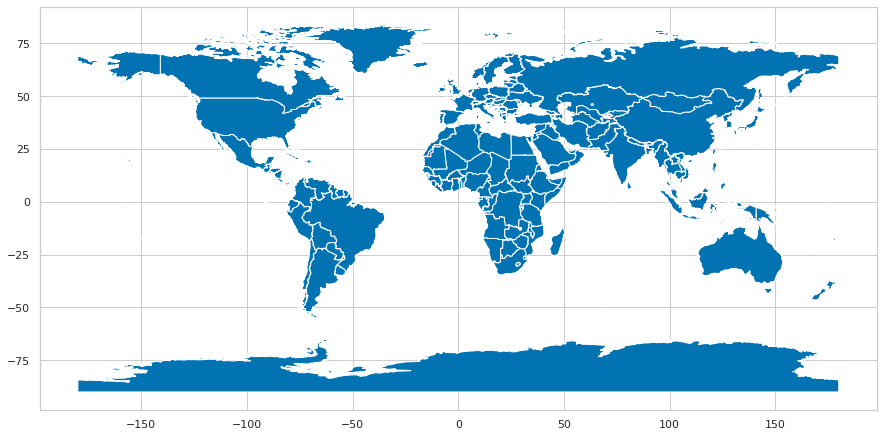

In [262]:
fig, ax = plt.subplots(figsize = (15, 15))
world_map.plot(ax = ax)

In [263]:
# Define a coordinate reference system (CRS)
crs = {'init': 'espg:4326'}

## Plot Counts by Hierarchy 00 (Country) by Wine Style

In [264]:
def count_style_country(grape):    
    df = df_Count_WS_All_00[(df_Count_WS_All_00.Grape_Blend == grape)]
    
    style = df['Wine_Style'].values
    style = style[0]

    geo_count = [Point(xy) for xy in zip( df['Longitude'], df['Latitude'])]

    geo_df = gpd.GeoDataFrame(
        df, 
        crs = crs, 
        geometry = geo_count
    )
    
    if style == 'Dessert & Fortified':
        color = 'purple'
    elif style == 'Red':
        color = 'red'
    elif style == 'Rosé | Rosado':
        color = 'red'
    elif style == 'Sparkling':
        color = 'green'
    elif style == 'White':
        color = 'green'

    fig, ax = plt.subplots(figsize = (15, 15))
    
    world_map.plot(ax = ax, alpha = 0.4, color = 'gray')

    geo_df.plot(ax=ax, markersize = geo_df['Count'], color = color, marker = 'o', label = 'Count of Scores')
    plt.legend(prop={'size': 15})
    plt.title(grape + '\nCount of Wine Spectator Scores by Country\nReview Years 1988-2020')
    
    plt.savefig('./images/count_scores_by_country_' + grape + '.png')
    plt.savefig('./images/count_scores_by_country_' + grape + '.jpg')

In [265]:
grapes = df_grape_style.Grape_Blend.unique()
grapes

array(['Brunello di Montalcino', 'Cabernet Sauvignon ', 'Champagne',
       'Chardonnay ', 'Chianti', 'Châteauneuf-du-Pape', 'Malbec ',
       'Merlot', 'Pinot Noir', 'Riesling', 'Rioja', 'Sangiovese',
       'Sauvignon Blanc', 'Shiraz | Syrah', 'Tempranillo', 'Zinfandel'],
      dtype=object)

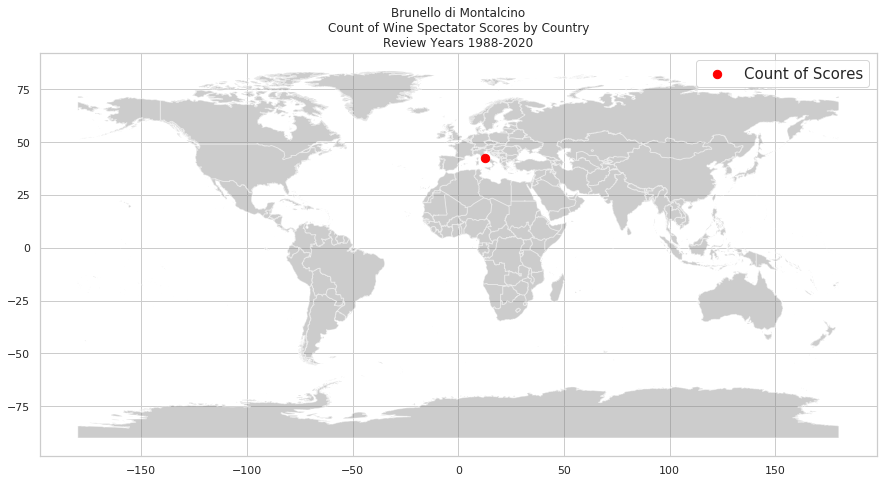

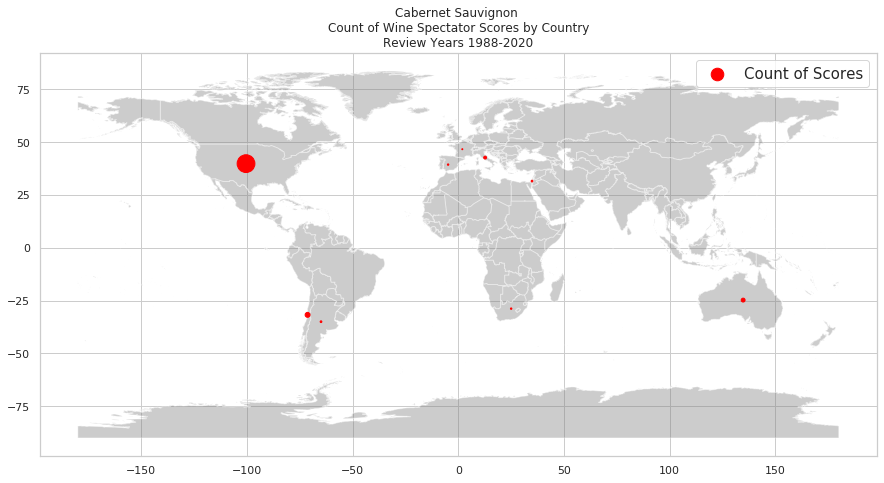

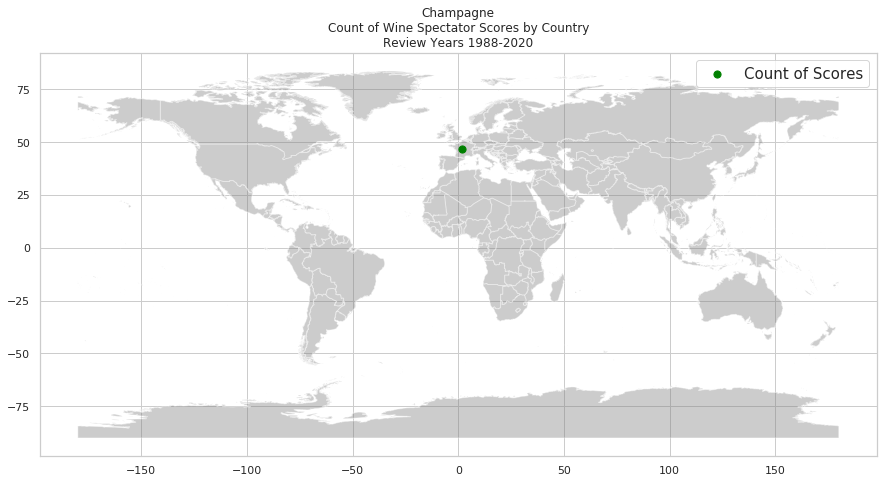

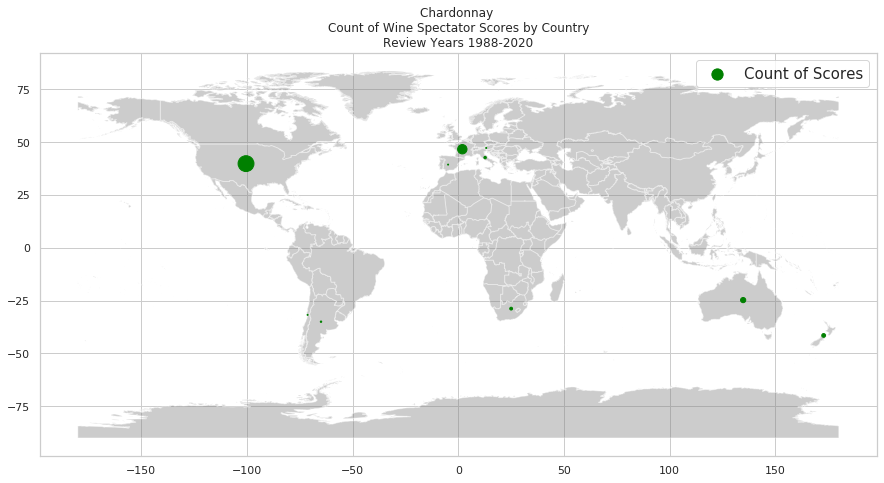

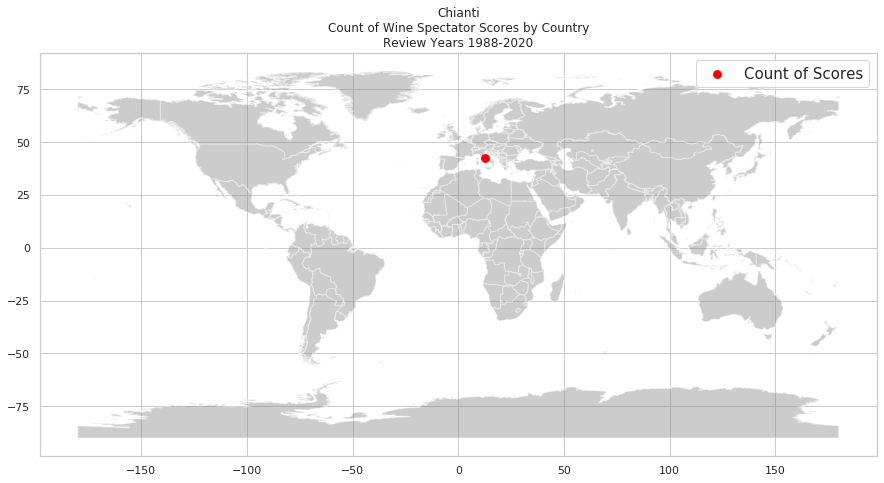

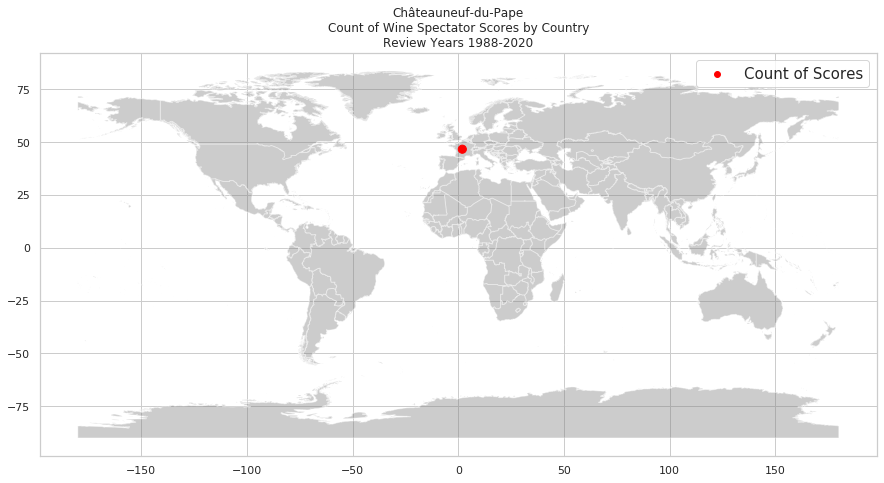

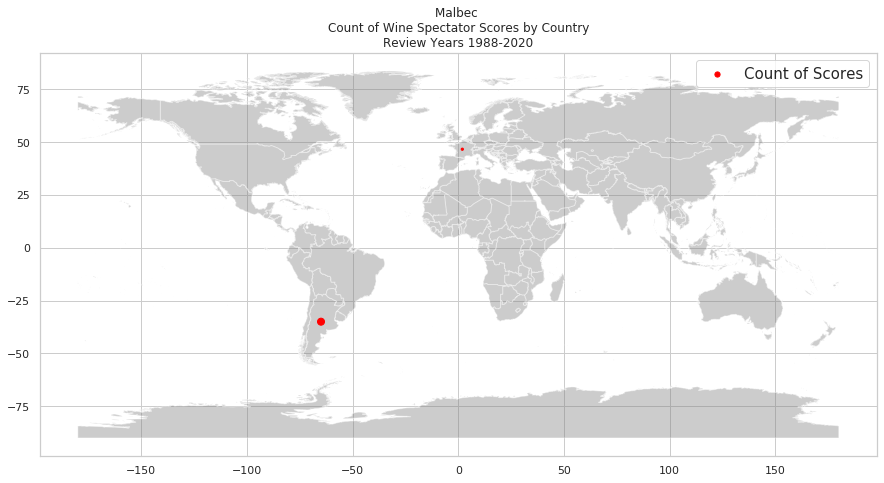

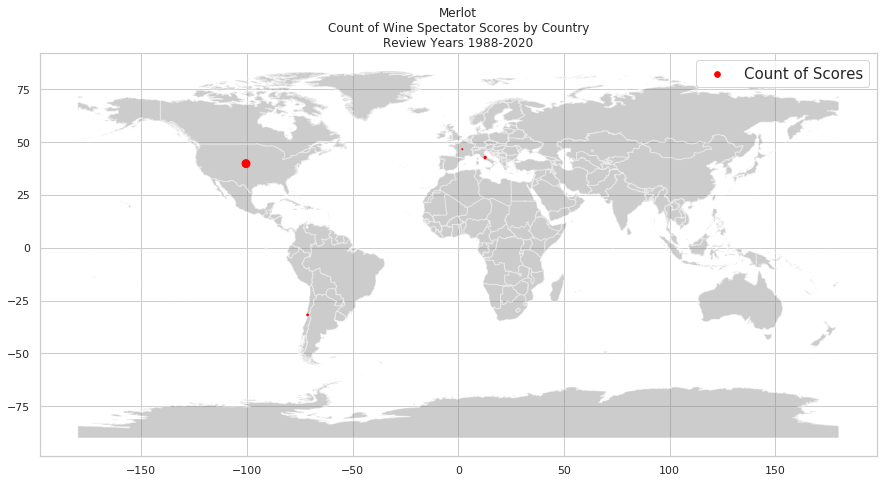

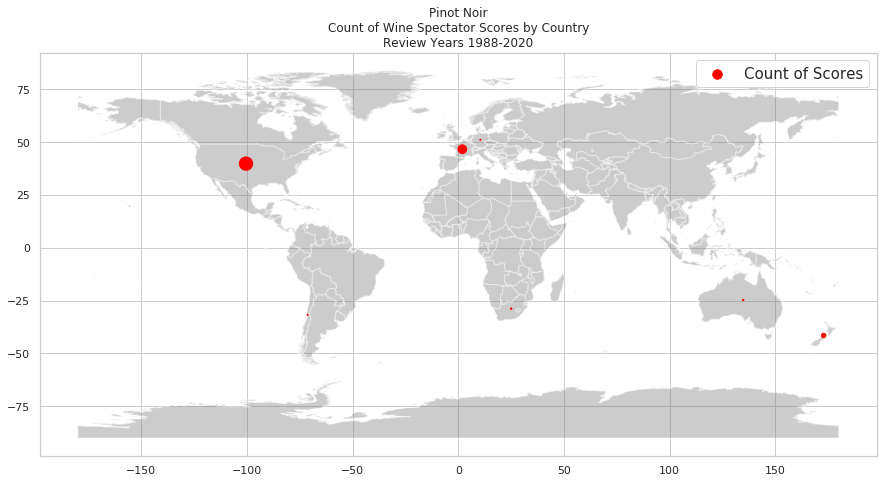

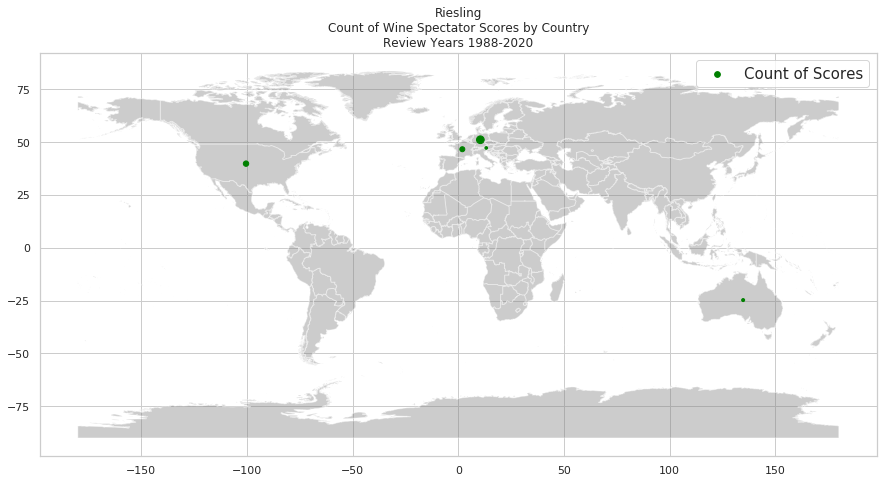

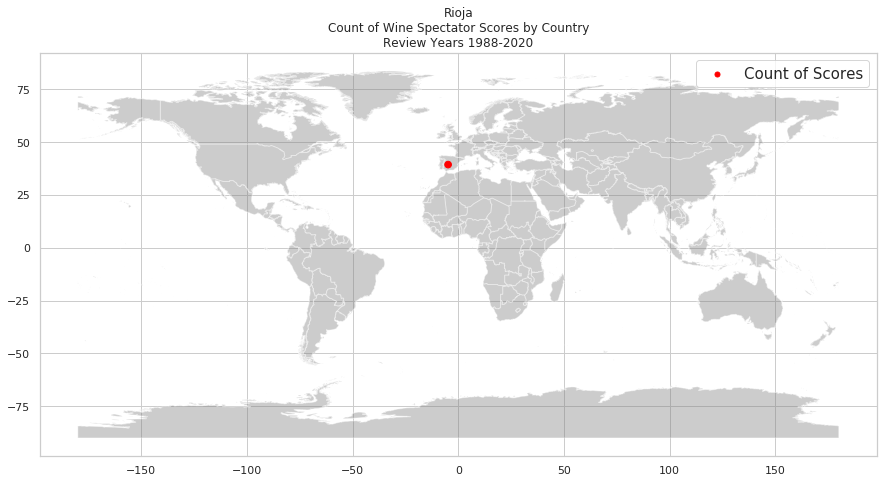

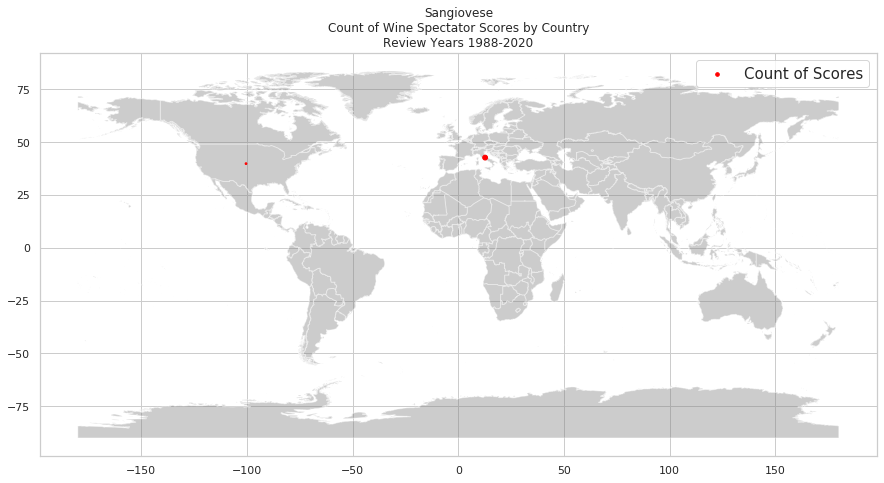

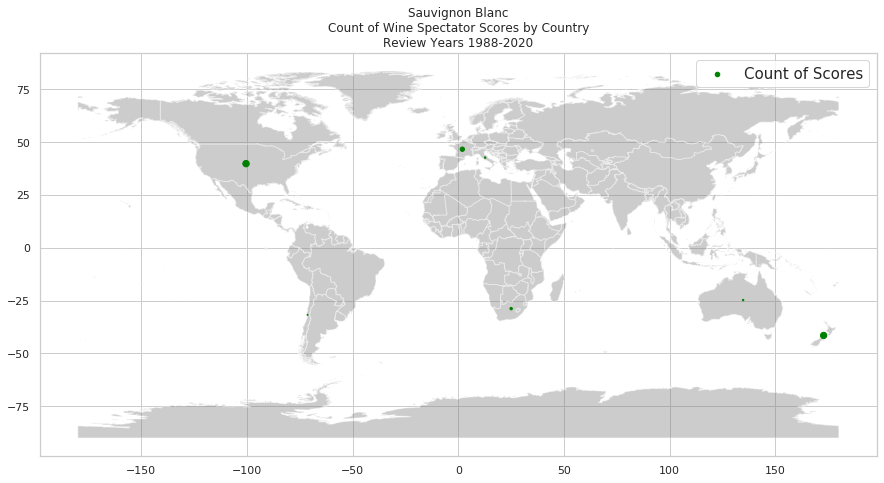

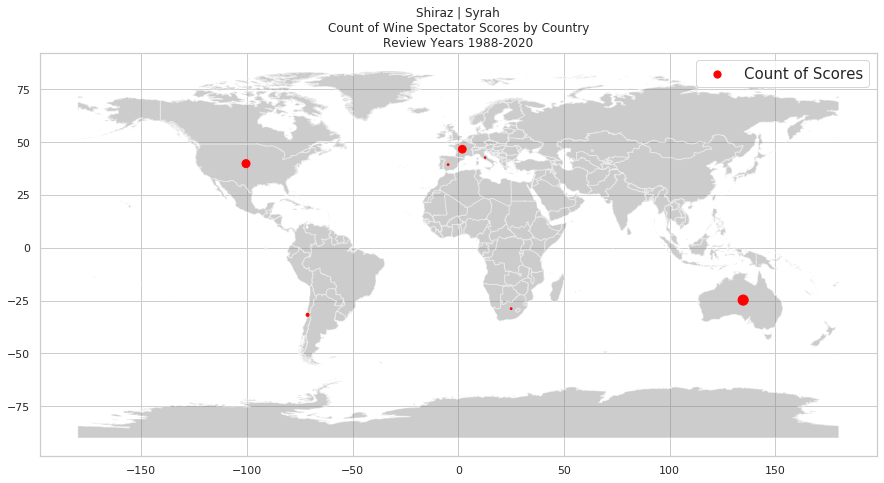

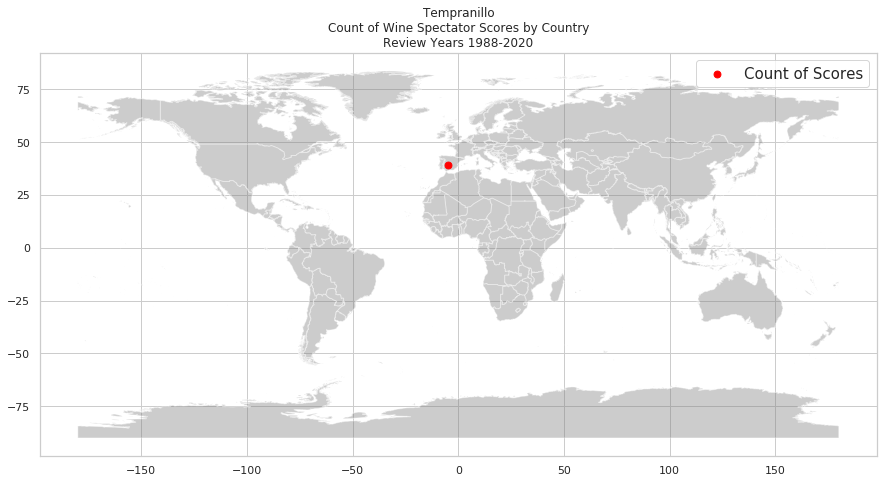

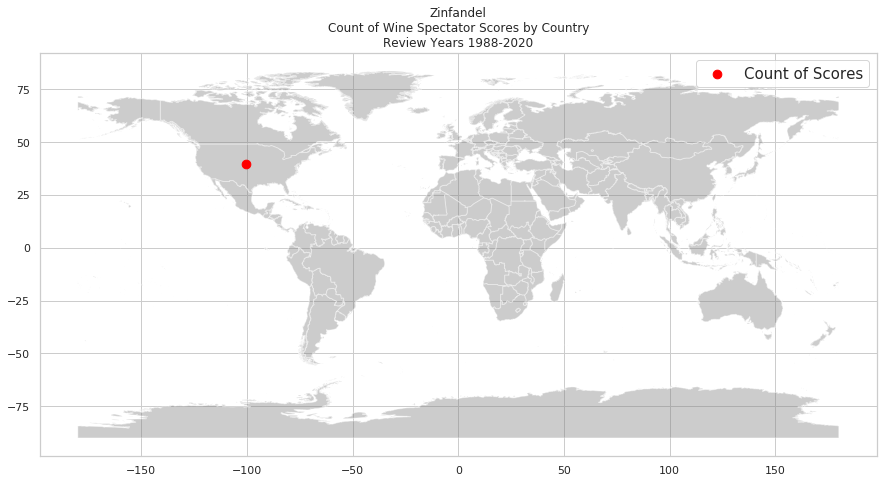

In [266]:
for grape in grapes:
    count_style_country(grape)

## Plot Counts by Hierarchy 01 (within Country)

In [267]:
# import country maps
usa_map = gpd.read_file('./shapefiles/USA/vw421bb8115.shp')
france_map = gpd.read_file('./shapefiles/France/ym781wr7170.shp')
italy_map = gpd.read_file('./shapefiles/Italy/bb489fv3314.shp')
europe_map = gpd.read_file('./shapefiles/Europe/yf665vp7551.shp')

In [268]:
def count_style_subcountry(grape, country):    
    df = df_Count_All_01[
        (df_Count_All_01.Grape_Blend == grape) #&
        #(df_Count_All_01.Address.str.contains(country) == True)
    ]
    
    if country == 'USA':
        country_map = usa_map
        bounds = 'State'
    elif country == 'France':
        country_map = france_map
        bounds = 'First-Level Administrative Division'
    elif country == 'Italy':
        country_map = italy_map
        bounds = 'First-Level Administrative Division'
    elif country == 'Europe':
        country_map = europe_map
        bounds = 'First-Level Administrative Division'
    else:
        print('select USA, France, or Italy as country')
        
    style = df['Wine_Style'].values
    style = style[0]
        
    if style == 'Dessert & Fortified':
        color = 'purple'
    elif style == 'Red':
        color = 'red'
    elif style == 'Rosé | Rosado':
        color = 'red'
    elif style == 'Sparkling':
        color = 'green'
    elif style == 'White':
        color = 'green'
    

    geo_count = [Point(xy) for xy in zip( df['Longitude'], df['Latitude'])]

    geo_df = gpd.GeoDataFrame(
        df, 
        crs = crs, 
        geometry = geo_count
    )

    fig, ax = plt.subplots(figsize = (10, 10))
    
    if country == 'USA':
        ax.set(xlim = (-130, -60), ylim = (20, 55))
    elif country == 'Europe':
        ax.set(xlim = (-15, 40), ylim = (35, 75))
    
    country_map.plot(ax = ax, alpha = 0.4, color = 'gray')

    geo_df.plot(ax=ax, markersize = geo_df['Count'] * 3, color = color, marker = 'o', label = 'Count of Scores')
    plt.legend(prop={'size': 15})
    plt.title(grape + '\nCount of Wine Spectator Scores by ' + bounds +'\nReview Years 1988-2020')
    
    fig.savefig('./images/count_scores_by_' + country + '_' + grape + '.png')
    fig.savefig('./images/count_scores_by_' + country + '_' + grape + '.jpg')

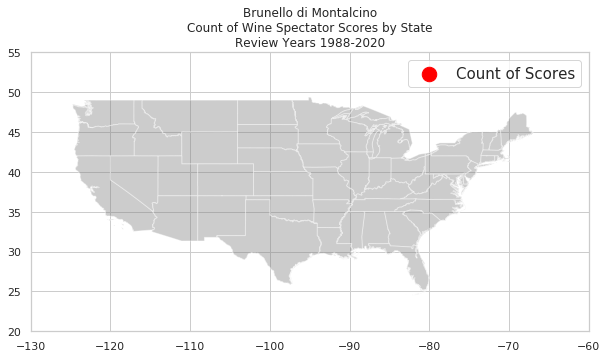

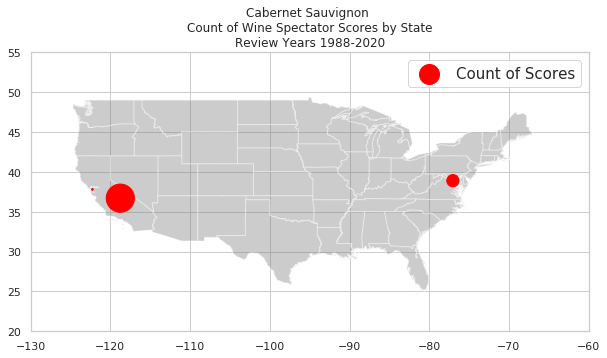

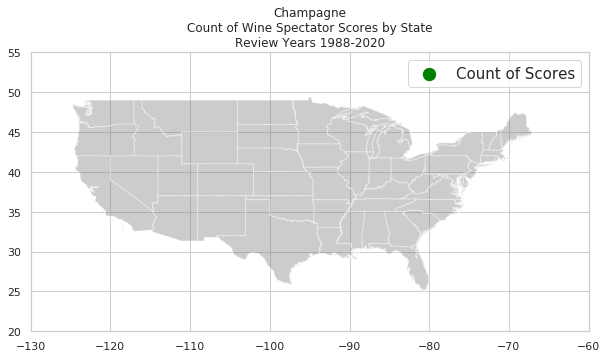

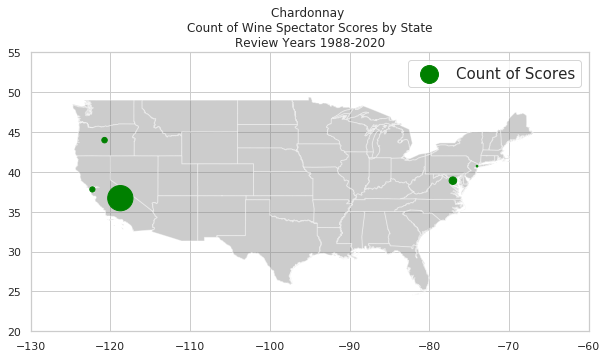

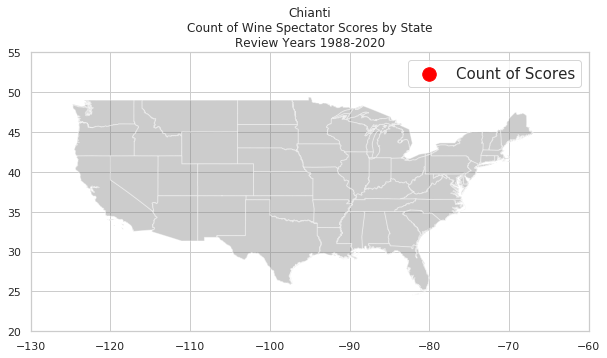

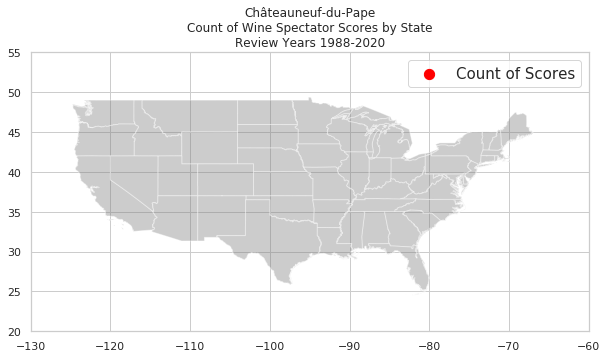

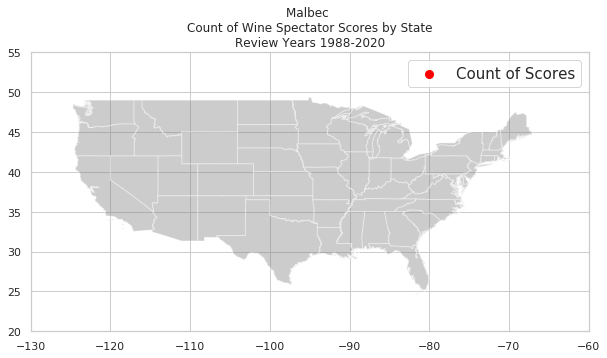

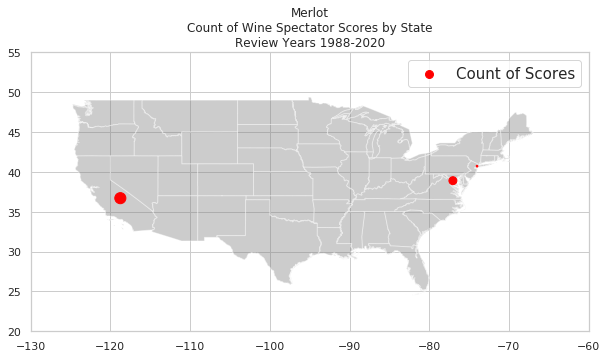

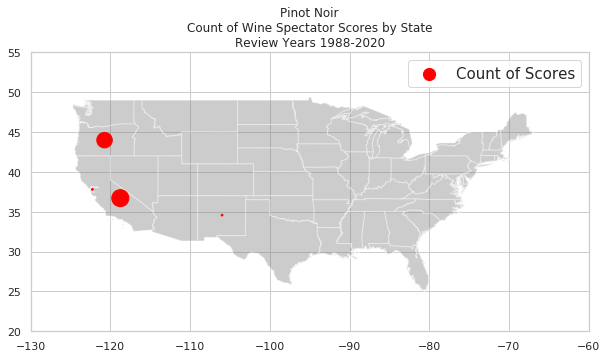

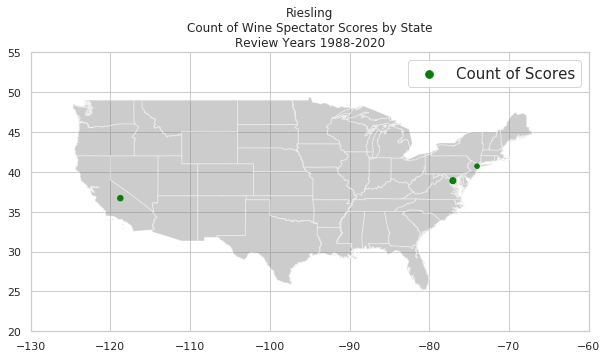

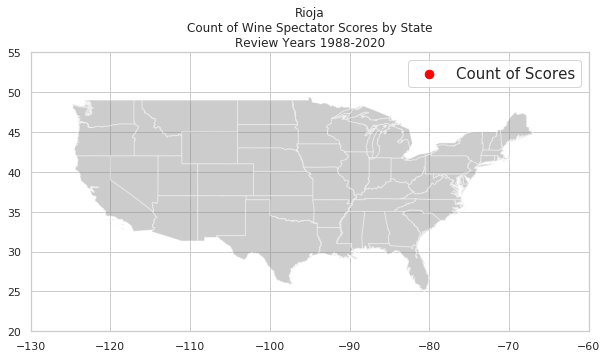

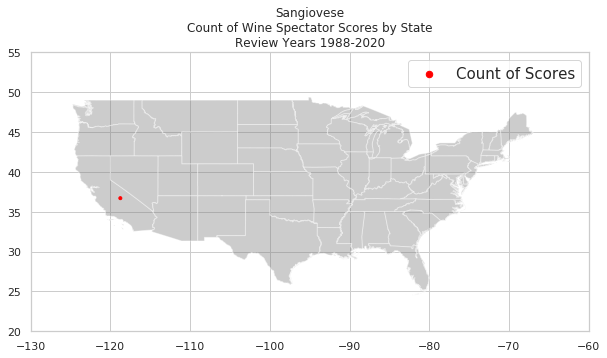

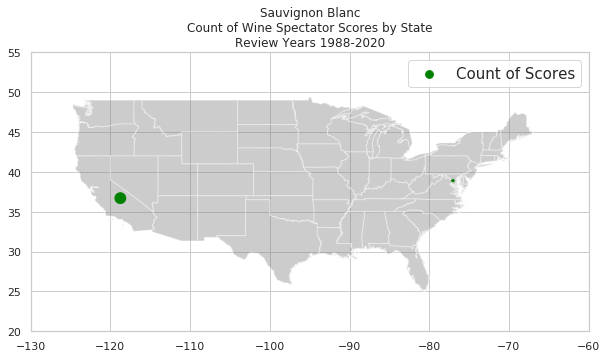

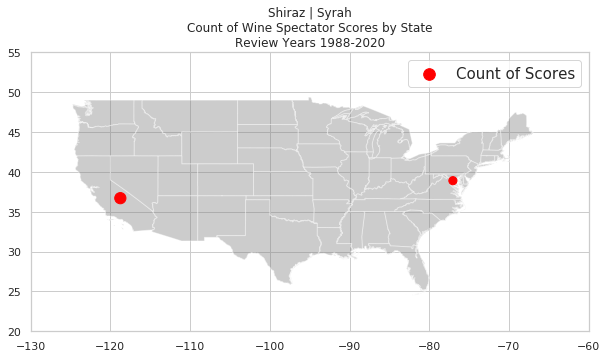

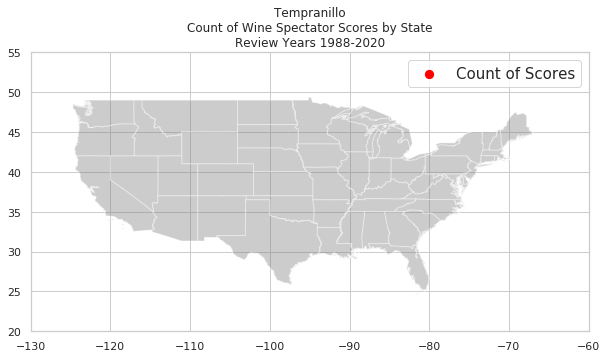

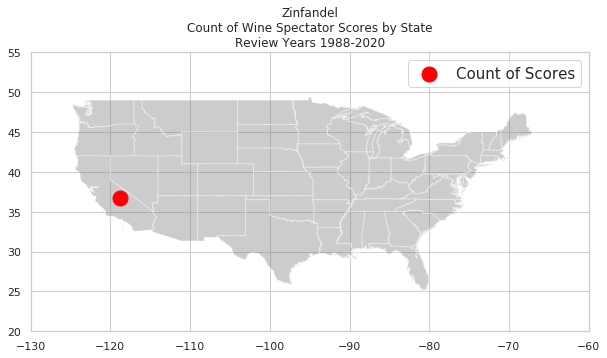

In [269]:
for grape in grapes:
    count_style_subcountry(grape, 'USA')

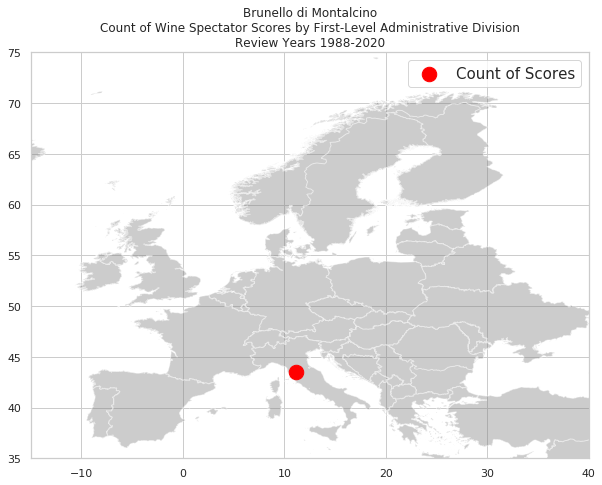

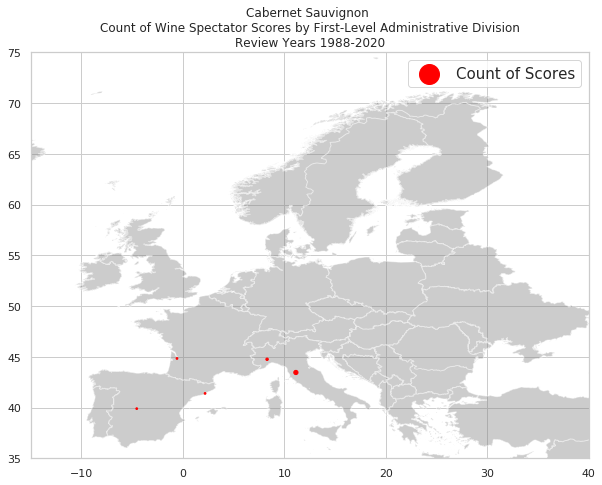

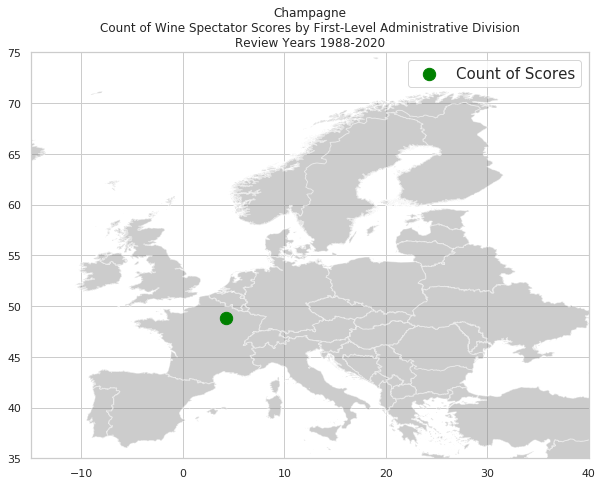

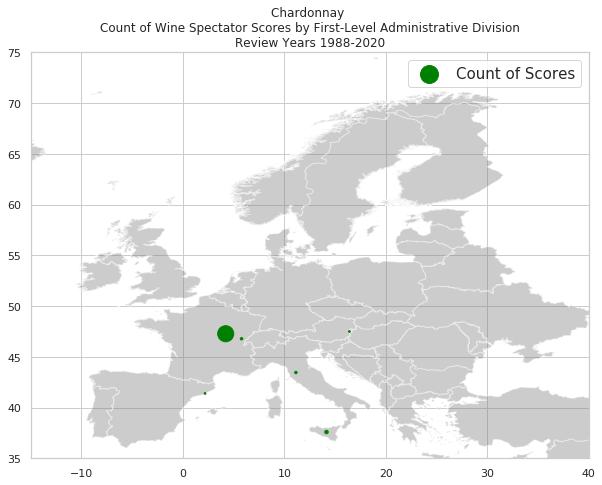

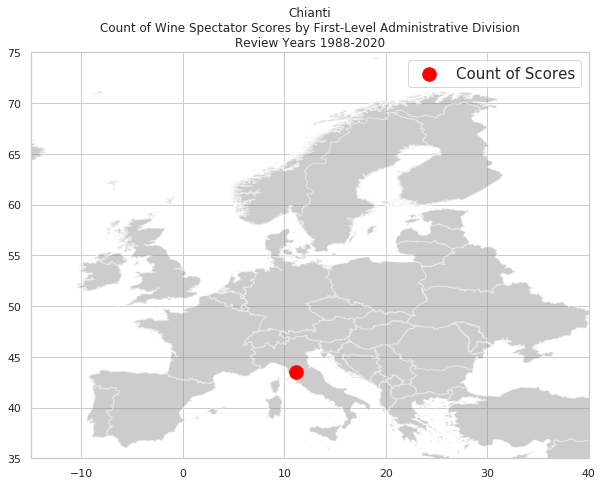

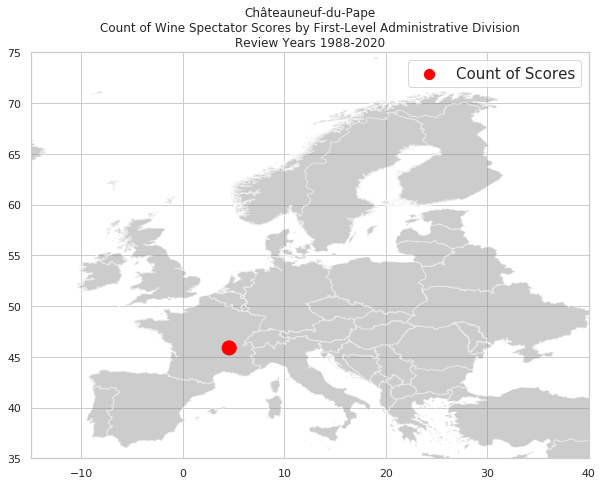

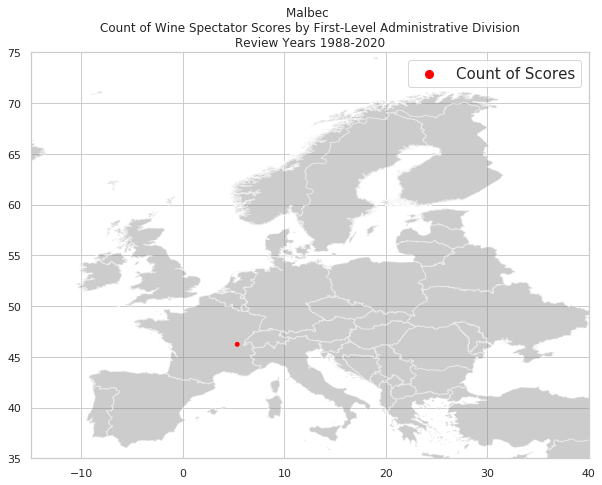

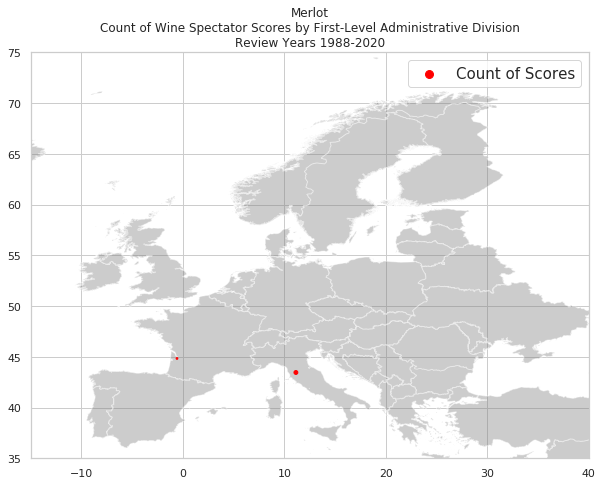

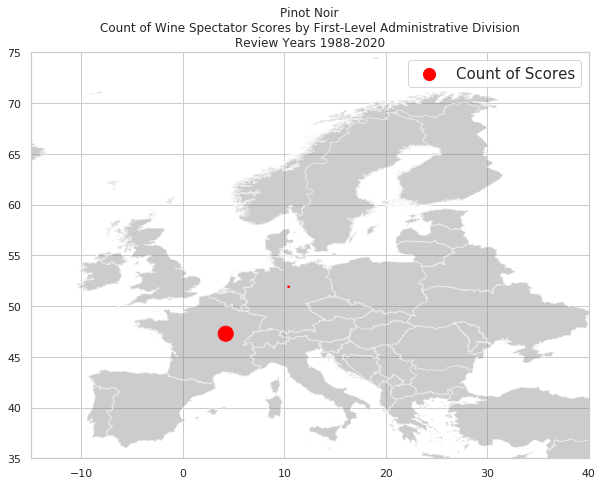

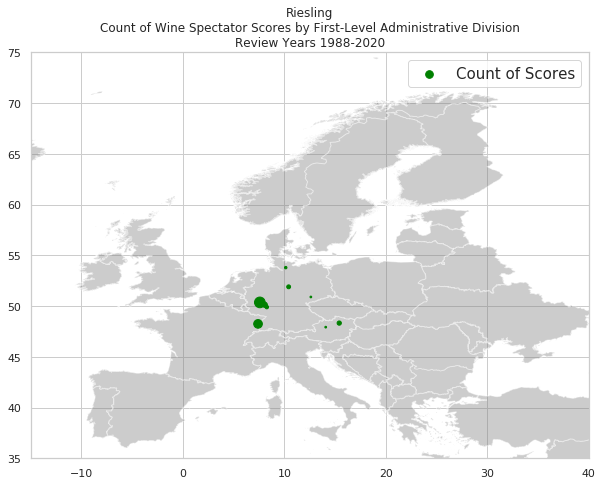

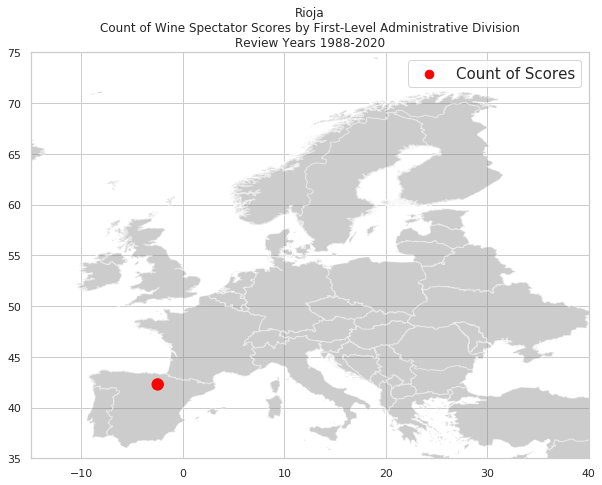

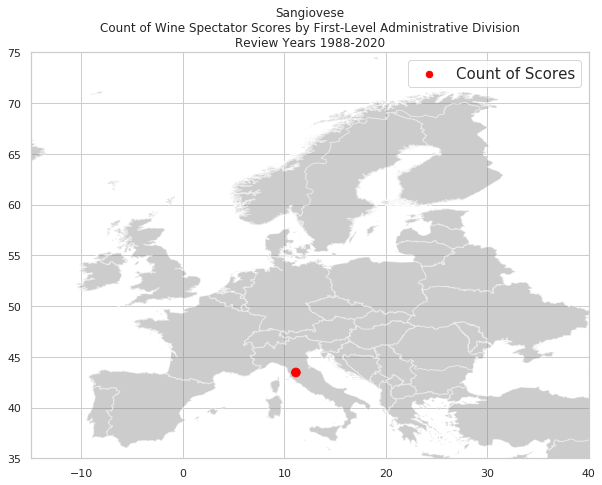

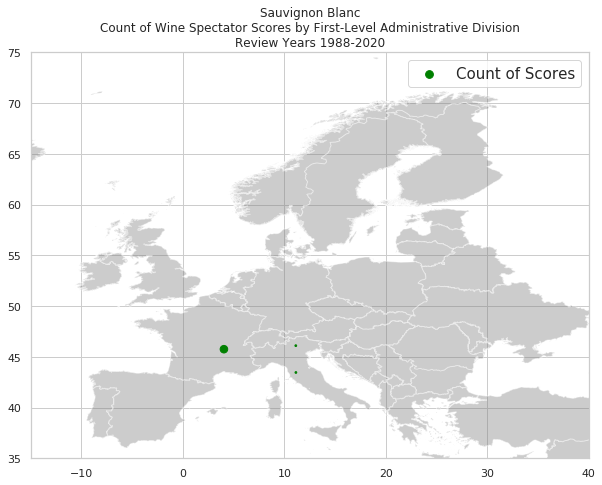

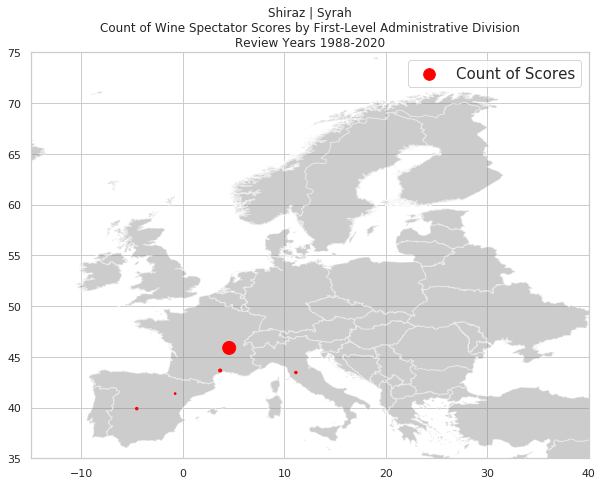

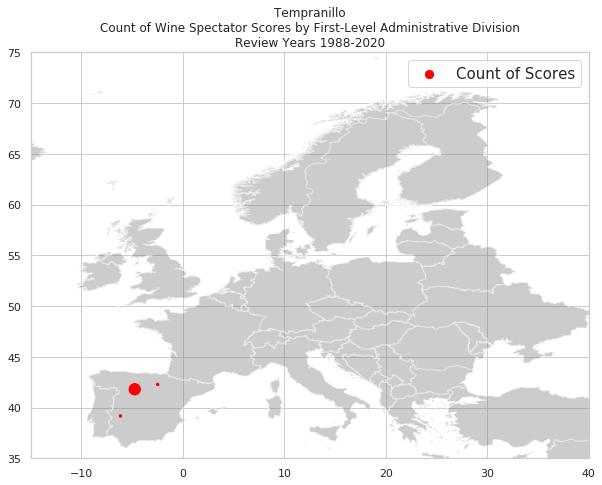

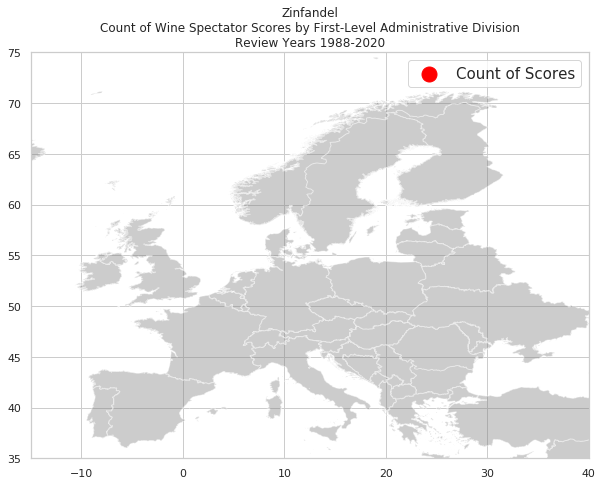

In [270]:
for grape in grapes:
    count_style_subcountry(grape, 'Europe')